In [30]:
import h5py
import numpy as np
from tqdm import tqdm
import pandas as pd
from astropy.time import Time

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [32]:
# Get times of GRBs
obrun = 'o2'
grb_file = h5py.File('./make_grb_background/background_merge_lgrb.hdf', 'r')

In [33]:
t_grb = []
name_grb = []
for k in grb_file.keys():
    t_grb.append(grb_file[k].attrs['gps'])
    name_grb.append(k)

In [34]:
t_grb = np.array(t_grb)
name_grb = np.array(name_grb)

In [35]:
days = (t_grb.max() - t_grb.min()) / 86400.0
npday_grb =  len(t_grb) / days
swait_grb = 86400 / npday_grb
print('Total GRB span time:',days,'days; average waiting time (s):', swait_grb)
print('There are',len(t_grb),'GRBs')

Total GRB span time: 2186.804117010418 days; average waiting time (s): 140059.2110524093
There are 1349 GRBs


In [36]:
gw_file = h5py.File('/work/yifan.wang/grb/gwrun/gwskymap/gwskymap_'+str(obrun)+'.hdf','r')

In [37]:
t_gw = []
name_gw = []
for k in tqdm(gw_file):
    t_gw.append(gw_file[k].attrs['gps'])
    name_gw.append(k)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144644/144644 [00:34<00:00, 4236.93it/s]


In [38]:
t_gw = np.array(t_gw)
name_gw = np.array(name_gw)

In [39]:
arggw = np.argsort(t_gw)
arggrb = np.argsort(t_grb)

In [40]:
sort_t_gw = t_gw[arggw]
sort_name_gw = name_gw[arggw]

sort_t_grb = t_grb[arggrb]
sort_name_grb = name_grb[arggrb]

In [41]:
def coincs(gw, grb, window=10):
    '''Function to search for temporal coincident GW and GRB signals
    
    Arguments:
    --------
    gw: np.array
        Gravitational wave candidates GPS time (sorted)
    grb: np.array
        Gamma-Ray burst candidates GPS time (sorted)
    windown: int, unit:s (default: 10)
        Time delay between GW and GRB
        
    Return:
    --------
    gwfound: np.array
        GW index for an associated pair
    grbfound: np.array
        GRB index for an associated pair
    '''
    gw = gw.copy()
    grb = grb.copy()
    left = np.searchsorted(grb, gw)
    right = np.searchsorted(grb, gw + window)

    gwfound = np.where((right - left) > 0)[0]
    grbfound = left[gwfound]
    return gwfound, grbfound

In [42]:
def getbstat(gw_name, gw_file, grb_name, grb_file):
    '''Function to get ranking statistic for a temporal associated pair
    
    Arguments:
    ----------
    gw_name: str
        Gravitational wave candidate name
    gw_file: hdf5 file
        A hdf5 file storing the GW skymap
    grb_name: str
        Long Gamma-ray Burst candidate name
    grb_file: hdf5 file
        A hdf5 file storing the GRB skymap
    '''
    gw_map = gw_file[gw_name][:]
    gw_stat = gw_file[gw_name].attrs['stat']
    grb_map = grb_file[grb_name][:]
    
    gw_map = np.array(gw_map)
    grb_map = np.array(grb_map)
    
    B = np.sum(gw_map*grb_map)*len(gw_map)/ (4*np.pi)
    if B <=0:
        return -np.inf
    else:
        return gw_stat + np.log(B)

# Search for foreground candidates

In [43]:
ind_gw, ind_grb = coincs(sort_t_gw, sort_t_grb,10)
cand_gwname = sort_name_gw[ind_gw]
cand_grbname = sort_name_grb[ind_grb]

In [44]:
ranking = []
for v_gwname, v_grbname in zip(cand_gwname,cand_grbname):
    bstat = getbstat(v_gwname, gw_file, v_grbname, grb_file)
    ranking.append(bstat)

In [45]:
ind_gw,ind_grb

(array([ 59027,  64867,  67280,  72680,  86205, 108158, 110316, 120890,
        144272]),
 array([501, 505, 507, 511, 522, 555, 557, 571, 593]))

In [46]:
cand_gwname

array(['170323_012316', '170330_222948', '170402_065048', '170409_024157',
       '170424_101224', '170626_093721', '170629_125329', '170723_161524',
       '170825_120003'], dtype='<U14')

In [47]:
cand_grbname

array(['GRB170323058', 'GRB170330A', 'GRB170402285', 'GRB170409112',
       'GRB170424425', 'GRB170626A', 'GRB170629A', 'GRB170723677',
       'GRB170825500'], dtype='<U12')

In [48]:
ranking

[-12.00498108453754,
 4.208204433416613,
 -3.253703240593129,
 -0.4586582631414411,
 -4.256205003859996,
 -5.139867882446251,
 -inf,
 -0.3378201155515299,
 -9.199387029635707]

# Determine sliding time for background estimation

In [49]:
#expnum = 1
#window = expnum * swait_grb / len(t_gw) / 2.0
#print(window)

window = 200
tslide = np.arange(-5000, -5) * window
tslide2 = np.arange(5, 5000) * window
tslide = np.concatenate([tslide, tslide2])

In [50]:
tslide

array([-1000000,  -999800,  -999600, ...,   999400,   999600,   999800])

In [51]:
# Calculate the background
bg_gwind = []
bg_grbind = []

for slide in tqdm(tslide):
    gwi, grbi = coincs(sort_t_gw, sort_t_grb + slide)
    bg_gwind.append(gwi)
    bg_grbind.append(grbi)
bg_gwind = np.concatenate(bg_gwind)
bg_grbind = np.concatenate(bg_grbind)
print(len(bg_gwind))

bg_ranking = []

bg_gwname = sort_name_gw[bg_gwind]
bg_grbname = sort_name_grb[bg_grbind]

for v_gwname, v_grbname in tqdm(zip(bg_gwname,bg_grbname)):
    bstat = getbstat(v_gwname, gw_file, v_grbname, grb_file)
    bg_ranking.append(bstat)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9990/9990 [00:59<00:00, 167.58it/s]


107611


107611it [01:52, 957.65it/s] 


# False alarm rate

In [52]:
bg_ranking = np.array(bg_ranking)
far = []
for i in ranking:
    far.append(len(bg_ranking[bg_ranking>=i])/len(tslide))

In [53]:
gw_gps = []
gw_stat = []
for name in cand_gwname:
    gw_stat.append(gw_file[name].attrs['stat'])
    gw_gps.append(gw_file[name].attrs['gps'])
grb_gps = []
for name in cand_grbname:
    grb_gps.append(grb_file[name].attrs['gps'])

In [54]:
result = {'gwname':cand_gwname,
          'gwtime':Time(gw_gps,format='gps',scale='utc').datetime64,
          'gwstat':gw_stat,
         'grbname':cand_grbname,
         'grbtime':Time(grb_gps,format='gps',scale='utc').datetime64,
          'rank_stat':ranking,
         'false_alarm_rate':far}
df = pd.DataFrame(result)
df.sort_values(by='false_alarm_rate',ascending=True,inplace=True)
df.to_csv('search_result_'+obrun+'.csv',index=False)

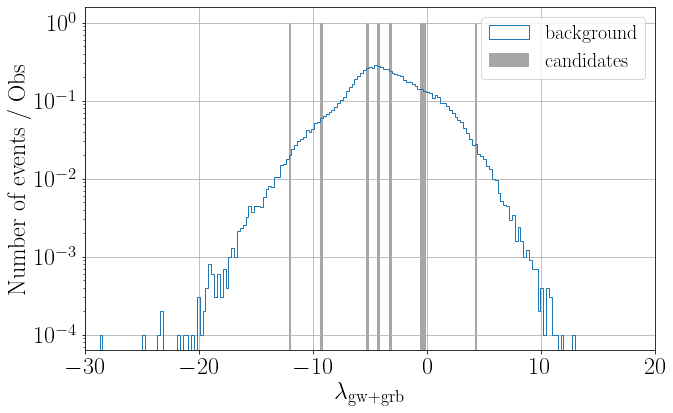

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)

low=-30
high=20
bins = np.linspace(low,high,200)
counts, _ = np.histogram(bg_ranking,bins=bins)

ax.hist(bins[:-1], bins, weights=counts/len(tslide),histtype="step",label='background')
ax.hist(ranking,bins=bins,alpha=0.7,color='grey',label='candidates')

ax.set_yscale('log')
ax.legend()
ax.set_xlim(low,high)
ax.set_xlabel('$\lambda_\mathrm{gw+grb}$')
ax.set_ylabel('Number of events / Obs')
fig.savefig(obrun+'.png',bbox_inches='tight')